# Wordcount using Kafka

![](https://camo.githubusercontent.com/56166d361c3975dee750ecce16d605bbbf66516b/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f352f35332f4170616368655f6b61666b615f776f7264747970652e737667)

In [31]:
from confluent_kafka import SerializingProducer, DeserializingConsumer
from confluent_kafka.serialization import StringSerializer, StringDeserializer
from confluent_kafka.admin import AdminClient, NewTopic
from uuid import uuid4
import sys, lorem, random

brokers = "kafka1:9092,kafka2:9093"
topics = ["sentences", "words", "lengths"]

In [32]:
new_topics = [NewTopic(topic, num_partitions=2, replication_factor=1) for topic in topics]

In [33]:
fs = a = AdminClient({'bootstrap.servers': brokers}).create_topics(new_topics)

## Producing Sentences

Non amet porro labore neque.
Amet adipisci dolore amet aliquam amet consectetur.
Neque ut neque porro non.
Quiquia dolore magnam eius.
Dolorem quiquia etincidunt magnam non.
Modi quiquia neque adipisci.
Ipsum modi ut neque.
Velit est velit est neque quiquia.
Neque dolorem velit amet quisquam quisquam.
Tempora etincidunt non quiquia magnam dolor dolore.
Sed amet dolore ipsum voluptatem.
Est neque quaerat aliquam eius.

In [5]:
pconf = {
    'bootstrap.servers': brokers,
    'partitioner': 'murmur2_random',
    'key.serializer': StringSerializer('utf_8'),
    'value.serializer': StringSerializer('utf_8')
}

In [6]:
p = SerializingProducer(pconf)

In [13]:
for n in range(1,100):
    try:
        # Produce line (without newline)
        line = lorem.sentence()
        p.produce(topics[0], key="key"+str(random.randint(0,1)), value=line)
        p.poll(0)
        p.flush()
        print(line)
    except BufferError:
        sys.stderr.write('%% Local producer queue is full (%d messages awaiting delivery): try again\n' % len(p))

Velit consectetur quaerat voluptatem ipsum voluptatem dolor quisquam.
Ipsum dolore eius ipsum tempora magnam velit.
Adipisci voluptatem tempora dolore amet ipsum.
Consectetur est tempora ut sit aliquam.
Ipsum ipsum non consectetur sed est sit.
Dolorem ipsum dolorem neque labore tempora.
Magnam eius eius dolorem ut.
Neque est quaerat adipisci neque.
Sed magnam quiquia sed consectetur tempora.
Magnam voluptatem velit voluptatem magnam dolor ipsum.
Sit dolorem tempora magnam modi dolor dolorem.
Quaerat dolore adipisci modi labore.
Labore magnam dolore amet dolore ipsum.
Etincidunt tempora dolor dolorem.
Velit etincidunt eius quiquia adipisci tempora dolore.
Dolore dolore velit modi ut sit.
Dolorem dolore aliquam labore quaerat aliquam.
Quiquia ipsum amet quisquam eius sit.
Modi sed est voluptatem.
Consectetur modi quaerat etincidunt porro sit.
Ipsum amet eius magnam.
Adipisci dolore adipisci eius dolorem ipsum dolorem consectetur.
Quaerat voluptatem est ut ipsum eius.
Magnam ut tempora ut

## Consuming Sentences

In [8]:
string_deserializer = StringDeserializer('utf_8')

In [122]:
consumer_conf = {
    'bootstrap.servers': brokers,
    'key.deserializer': string_deserializer,
    'value.deserializer': string_deserializer,
    'group.id': str(uuid4()),
    'session.timeout.ms': 6000,
    'auto.offset.reset': 'earliest'
}

In [123]:
c = DeserializingConsumer(consumer_conf)
c.subscribe([topics[0]])

In [124]:
try:
    while True:
        # SIGINT can't be handled when polling, limit timeout to 1 second.
        msg = c.poll(1.0)
        if msg is None:
            continue
        if msg.error():
            raise KafkaException(msg.error())
        else:
            print("{} [{}] at offset  {} with key  {}:  {}".format(msg.topic(), msg.partition(), msg.offset(), str(msg.key()), str(msg.value())))
except KeyboardInterrupt:
    sys.stderr.write('%% Aborted by user\n')
finally:
    # Close down consumer to commit final offsets.
    c.close()

sentences [0] at offset  0 with key  7cafcf71-386a-47a5-a3df-358feedc52db:  Dolore porro aliquam neque adipisci numquam neque.
sentences [0] at offset  1 with key  2df8fcce-aad7-4118-abf9-8dfc31a45599:  Ut consectetur est adipisci numquam.
sentences [0] at offset  2 with key  c4fe9d1d-7e8a-4378-983f-11e22354d554:  Ut etincidunt modi velit.
sentences [0] at offset  3 with key  2233e624-013d-42be-a3c5-aa41b69abe87:  Non velit velit voluptatem modi tempora labore.
sentences [0] at offset  4 with key  189672eb-f73a-4416-b283-d87bc2d9a3f1:  Dolorem numquam quiquia modi consectetur.
sentences [0] at offset  5 with key  f0c48a72-2c52-4571-8db3-a36f540e591f:  Porro ipsum modi ut dolor quiquia.
sentences [0] at offset  6 with key  2e49105a-4917-41b7-b11c-3cacadddacab:  Non etincidunt labore modi dolor quiquia.
sentences [0] at offset  7 with key  11a6ec0c-1d01-4703-b705-5ae0a9b7ab6e:  Non adipisci magnam tempora est dolor labore consectetur.
sentences [0] at offset  8 with key  5e293888-2aca-41

%% Aborted by user


## Consuming Sentences and Producing Words

In [22]:
from confluent_kafka.serialization import IntegerSerializer, IntegerDeserializer

consumer_conf['group.id'] = str(uuid4())
c2 = DeserializingConsumer(consumer_conf)
c2.subscribe([topics[0]])

pconf = {
    'bootstrap.servers': brokers,
    'key.serializer': StringSerializer('utf_8'),
    'value.serializer': IntegerSerializer()
}


p2 = SerializingProducer(pconf)

In [121]:
try:
    while True:
        # SIGINT can't be handled when polling, limit timeout to 1 second.
        msg = c2.poll(1.0)
        if msg is None:
            continue
        if msg.error():
            raise KafkaException(msg.error())
        else:
            for w in msg.value().split(" "):
                print(w)
                p2.produce(topics[1], key=w, value=int(1))
                p2.poll(0)
                p2.flush()
except KeyboardInterrupt:
    sys.stderr.write('%% Aborted by user\n')
finally:
    # Close down consumer to commit final offsets.
    c2.close()

RuntimeError: Consumer closed

## Counting Words

In [24]:
consumer_conf['group.id'] = str(uuid4())
consumer_conf['value.deserializer'] = IntegerDeserializer()

words = {}

In [25]:
c3 = DeserializingConsumer(consumer_conf)
c3.subscribe([topics[1]])

In [26]:
try:
    while True:
        # SIGINT can't be handled when polling, limit timeout to 1 second.
        msg = c3.poll(1.0)
        if msg is None:
            continue
        if msg.error():
            raise KafkaException(msg.error())
        else:
            w = str(msg.key())
            if w in words:
                words[w] = words[w] + msg.value()
            else:
                words[w] = msg.value()
except KeyboardInterrupt:
    sys.stderr.write('%% Aborted by user\n')
finally:
    # Close down consumer to commit final offsets.
    c3.close()

%% Aborted by user


In [28]:
words

{'Dolore': 8,
 'porro': 25,
 'aliquam': 24,
 'neque': 36,
 'adipisci': 36,
 'numquam': 25,
 'neque.': 8,
 'Ut': 14,
 'consectetur': 28,
 'est': 25,
 'numquam.': 6,
 'etincidunt': 16,
 'modi': 32,
 'velit.': 7,
 'Non': 10,
 'velit': 29,
 'voluptatem': 35,
 'tempora': 30,
 'labore.': 8,
 'Dolorem': 10,
 'quiquia': 35,
 'consectetur.': 10,
 'Porro': 6,
 'ipsum': 34,
 'ut': 27,
 'dolor': 25,
 'quiquia.': 8,
 'labore': 21,
 'magnam': 34,
 'quaerat': 33,
 'Quaerat': 13,
 'modi.': 2,
 'Est': 9,
 'sed.': 8,
 'Adipisci': 14,
 'amet': 39,
 'eius.': 12,
 'Amet': 9,
 'dolorem': 21,
 'non': 18,
 'dolorem.': 9,
 'sed': 29,
 'dolore': 39,
 'Eius': 5,
 'eius': 26,
 'quaerat.': 6,
 'Aliquam': 6,
 'sit.': 8,
 'quisquam': 22,
 'amet.': 3,
 'Etincidunt': 5,
 'Quisquam': 1,
 'adipisci.': 5,
 'porro.': 7,
 'Dolor': 4,
 'quisquam.': 9,
 'sit': 27,
 'Neque': 11,
 'aliquam.': 11,
 'Labore': 7,
 'non.': 5,
 'ut.': 6,
 'dolor.': 6,
 'Modi': 8,
 'Quiquia': 14,
 'Magnam': 9,
 'etincidunt.': 14,
 'Consectetur': 5,


In [29]:
import numpy as np
import matplotlib.pyplot as plt

<BarContainer object of 81 artists>

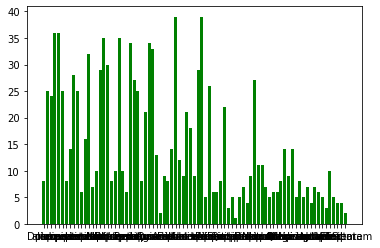

In [30]:
plt.bar(words.keys(), words.values(), color='g')

# Consuming Sentences and producing words lengths

In [43]:
topics[0]

'sentences'

In [126]:
consumer_conf['group.id'] = str(uuid4())
c4 = DeserializingConsumer(consumer_conf)
c4.subscribe([topics[0]])

pconf = {
    'bootstrap.servers': brokers,
    'key.serializer': StringSerializer('utf_8'),
    'value.serializer': IntegerSerializer()
}


p2 = SerializingProducer(pconf)

In [128]:
import time

In [129]:
try:
    while True:
        # SIGINT can't be handled when polling, limit timeout to 1 second.
        msg = c4.poll(1.0)
        if msg is None:
            continue
        if msg.error():
            raise KafkaException(msg.error())
        else:
            for w in msg.value().split(" "):
                print(w)
                p2.produce(topics[2], key=w, value=int(len(w)))
                p2.poll(0)
                p2.flush()
                time.sleep(5)
except KeyboardInterrupt:
    sys.stderr.write('%% Aborted by user\n')
finally:
    # Close down consumer to commit final offsets.
    c4.close()

Dolore
porro
aliquam
neque
adipisci
numquam
neque.
Ut
consectetur


%% Aborted by user


## Identifying the Max

In [151]:
consumer_conf = {
    'bootstrap.servers': brokers,
    'key.deserializer': string_deserializer,
    'value.deserializer': IntegerDeserializer(),
    'group.id': str(uuid4()),
    'session.timeout.ms': 6000,
    'auto.offset.reset': 'earliest'
}

In [152]:
c5 = DeserializingConsumer(consumer_conf)
c5.subscribe([topics[2]])

window = [-1, -1] # opening and closing instance
buffer = []

In [153]:
try:
    while True:
        # SIGINT can't be handled when polling, limit timeout to 1 second.
        msg = c5.poll(1)
        if msg is None:
            continue
        if msg.error():
            raise KafkaException(msg.error())
        else:
            if(window[0]==-1):
                window[0]=msg.timestamp()[1]
                window[1]=msg.timestamp()[1]+4*100
                buffer.append(msg.value())
            elif (msg.timestamp()[1]> window[1]):
                print(buffer)
                print(sum(buffer) / len(buffer))
                old = window[1]
                window[0]= old
                window[1]= old +4*100
                buffer = [msg.value()]
            else:
                buffer.append(msg.value())
except KeyboardInterrupt:
    sys.stderr.write('%% Aborted by user\n')
finally:
    # Close down consumer to commit final offsets.
    c5.close()

[6]
6.0
[5]
5.0
[7]
7.0
[5]
5.0
[8, 7, 6, 2, 11, 3, 8, 8, 2, 10, 4, 6, 3, 5, 5, 10, 4, 7]
6.055555555555555
[7, 7, 7, 7, 4, 12, 5, 5, 4, 2, 5, 8, 3, 10, 6, 4, 5, 8, 3, 8, 6, 7, 3, 5, 6, 12, 3, 4, 7, 10, 6, 4, 6, 6, 7, 7, 11, 5, 3, 6, 10, 7, 8, 4, 8, 5, 10, 5, 4, 5, 4, 7, 7, 8, 7, 8, 8, 5, 7, 4, 4]
6.213114754098361
[3, 8, 3, 3, 7, 7, 6, 7, 3, 10, 5, 3, 5, 4, 2, 7, 4, 4, 7, 4, 8, 7, 7, 4, 7, 4, 2, 7, 6, 8, 8, 4, 5, 6, 3, 5, 4, 5, 5, 3, 10, 3, 10, 8, 10, 5, 3, 5, 5, 8, 6, 8, 5, 7, 8, 8, 4, 3, 4]
5.593220338983051
[5, 9, 8, 8, 10, 2, 6, 5, 2, 5, 7, 5, 4, 6, 8, 7, 8, 7, 7, 7, 4, 12, 6, 5, 3, 9, 8, 5, 5, 12, 6, 10, 3, 7, 6, 7, 4, 7, 8, 3, 7, 3, 5, 6, 8, 5, 7, 3, 4, 8, 6, 5, 3, 10, 7, 5, 5, 7]
6.206896551724138
[11, 5, 5, 5, 5, 6, 7, 5, 4, 2, 7, 8, 4, 3, 5, 4, 4, 3, 6, 4, 6, 6, 4, 3, 4, 7, 6, 7, 7, 5, 8, 5, 3, 5, 6, 7, 3, 2, 6, 8, 7, 3, 8, 7, 4, 4, 7, 5, 4, 6, 7, 2, 5, 5, 6, 11, 11, 7, 11, 11, 2]
5.639344262295082
[7, 4, 7, 10, 8, 7, 7, 7, 3, 11, 3, 4, 4, 6, 3, 4, 5, 8, 11, 7, 5, 5, 5, 7, 11

%% Aborted by user


In [150]:
buffer

[11]